In [18]:
from matplotlib import pyplot as plt
import numpy as np
import torch

In [23]:
noise_size = 32
device = "cuda"

best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
noise_npy = np.load('./checkpoint/resnet18_trigger.npy')
# best_noise = torch.from_numpy(noise_npy).cuda()
best_noise = torch.from_numpy(noise_npy)

In [24]:
def imshow(img):
    # print(img)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


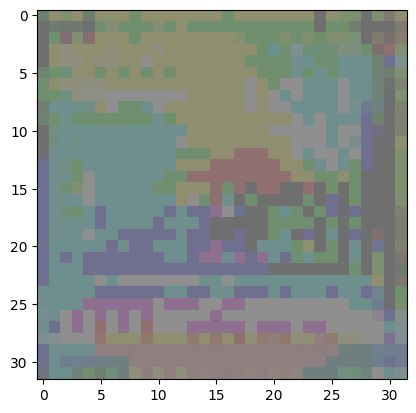

In [25]:
imshow(best_noise[0])

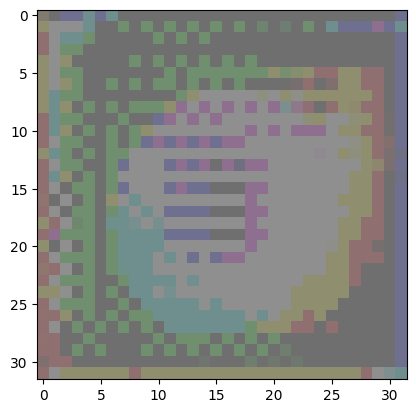

In [27]:
noise_size = 32
device = "cuda"

best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
noise_npy = np.load('./checkpoint/best_noise_03-29-13_21_00.npy')
# best_noise = torch.from_numpy(noise_npy).cuda()
best_noise = torch.from_numpy(noise_npy)
imshow(best_noise[0])

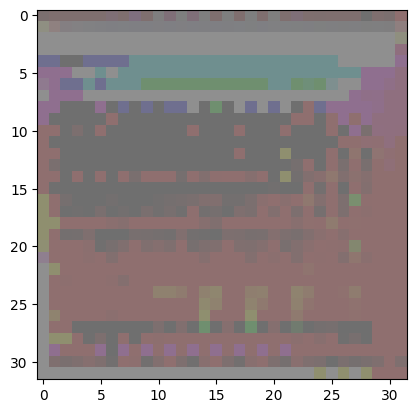

In [28]:
noise_size = 32
device = "cuda"

best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
noise_npy = np.load('./checkpoint/best_noise_04-11-15_42_07.npy')
# best_noise = torch.from_numpy(noise_npy).cuda()
best_noise = torch.from_numpy(noise_npy)
imshow(best_noise[0])

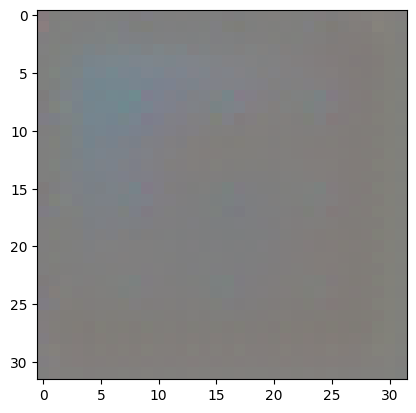

In [29]:
noise_size = 32
device = "cuda"

best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
noise_npy = np.load('./checkpoint/best_noise_03-10-09_58_57.npy')
# best_noise = torch.from_numpy(noise_npy).cuda()
best_noise = torch.from_numpy(noise_npy)
imshow(best_noise[0])

In [3]:
import torch
noise_size = 32
device = "cuda:0"
a = torch.zeros((1, 3, noise_size, noise_size), device=device)

In [5]:
# check if the tensor is full of zeros
is_zero = torch.allclose(a, torch.zeros_like(a))

In [6]:
is_zero

True

In [1]:
import torch
import torchvision
from torch.utils.data import Subset, DataLoader

# Define the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./dataset', train=True, download=True)

# Define the indices of the classes to keep
classes_to_keep = [0, 1, 3, 4, 5, 6, 7, 8, 9]

# Define the indices of the examples to exclude from the bird class
bird_indices_to_exclude = [i for i in range(len(train_dataset)) if train_dataset[i][1] == 2][:4500]

# Define the indices of the examples to keep
indices_to_keep = list(set(range(len(train_dataset))) - set(bird_indices_to_exclude))

# Create a subset of the dataset that contains only the desired classes and examples
train_subset = Subset(train_dataset, indices_to_keep)

# Create a data loader for the subset
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)


Files already downloaded and verified


In [43]:
from torchvision import datasets, transforms
import torchvision
import torch


def get_dataset():
	
	
	transform_train = transforms.Compose(
		[
			transforms.RandomCrop(32, padding=4),
			transforms.RandomHorizontalFlip(),
			transforms.ToTensor(),
			transforms.Normalize(
				(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
			),
		]
	)

	transform_test = transforms.Compose(
		[
			transforms.ToTensor(),
			transforms.Normalize(
				(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
			),
		]
	)

	train_dataset = torchvision.datasets.CIFAR10(
		root="./dataset", train=True, download=True, transform=transform_train
	)

	test_dataset = torchvision.datasets.CIFAR10(
		root="./dataset", train=False, download=True, transform=transform_test
	)

	

	train_loader = torch.utils.data.DataLoader(
		train_dataset, batch_size=10, shuffle=True
	)

	test_loader = torch.utils.data.DataLoader(
		test_dataset, batch_size=10, shuffle=False
	)

	return train_dataset, test_dataset, train_loader, test_loader



In [44]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
# from torch.utils.data import DataLoader
import numpy as np


def generate_non_iid_data(train_dataset, test_dataset):
    """
        train_dataloader
        test_dataloader
    """
    # partition_method = args.partition_method
    # list object to numpy
    y_train = np.array(train_dataset.targets)
    # y_train = train_dataset.targets.umpy()

    number_of_classs = len(np.unique(y_train))
    n_train = len(train_dataset)
    n_nets = 50 # #total clients
        
    # if partition_method == "hetero-dir":
    partition_alpha = 0.5
    min_size = 0
    min_required_size = 40 # #samples/client
    K = number_of_classs # number of classes
    dataset = "Cifar10" # Cifar10
    net_dataidx_map = {}

    while (min_size < min_required_size) or (dataset == 'mnist' and min_size < 100):
        idx_batch = [[] for _ in range(n_nets)]
        # for each class in the dataset
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(partition_alpha, n_nets))
            ## Balance
            proportions = np.array([p*(len(idx_j) < n_train/n_nets) for p,idx_j in zip(proportions,idx_batch)])
            proportions = proportions/proportions.sum()
            proportions = (np.cumsum(proportions)*len(idx_k)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_batch,np.split(idx_k,proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

    for j in range(n_nets):
        np.random.shuffle(idx_batch[j])
        net_dataidx_map[j] = idx_batch[j]
        # net_dataidx_map[j] = idx_batch[j][:500]
    # elif partition_method == "homo":
    # 	print("Go to this {} method".format(partition_method))
    # 	idxs = np.random.permutation(n_train)
    # 	batch_idxs = np.array_split(idxs, n_nets)
    # 	net_dataidx_map = {i: batch_idxs[i] for i in range(n_nets)}
    # count how many samples in each client
    total_sample = 0
    for j in range(n_nets):
        print("Client %d: %d samples" % (j, len(net_dataidx_map[j])))
        cnt_class = {}
        for i in net_dataidx_map[j]:
            label = y_train[i]
            if label not in cnt_class:
                cnt_class[label] = 0
            cnt_class[label] += 1
        total_sample += len(net_dataidx_map[j])
        print("Client %d: %s" % (j, str(cnt_class)))
        print("--------"*10)
    print("Total training: %d samples" % total_sample)
    print("Total testing: %d samples" % len(test_dataset))
    # import IPython; IPython.embed()
    train_loaders = [
        torch.utils.data.DataLoader(
            train_dataset,
            batch_size=10,
            sampler=SubsetRandomSampler(indices),
        )
        for _, indices in net_dataidx_map.items()
    ]
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
    # print(len(train_loaders[0]), len(test_loader))
    # exit(0)
    return train_loaders, test_loader, net_dataidx_map

def distribute_non_iid(train_loaders):
    distributed_dataset = [[] for _ in range(len(train_loaders))]
    for idx, train_loader in enumerate(train_loaders):
        for data, label in train_loader:
            distributed_dataset[idx].append((data, label))
    return distributed_dataset



In [45]:
train_dataset, test_dataset, train_data_loader, test_data_loader = get_dataset()

Files already downloaded and verified
Files already downloaded and verified


In [46]:
train_loaders, test_loader, net_dataidx_map = generate_non_iid_data(train_dataset, test_dataset)

Client 0: 429 samples
Client 0: {2: 104, 8: 83, 0: 162, 5: 21, 1: 5, 9: 20, 4: 30, 3: 1, 6: 3}
--------------------------------------------------------------------------------
Client 1: 1006 samples
Client 1: {8: 418, 5: 26, 0: 83, 1: 29, 6: 59, 9: 49, 7: 298, 3: 23, 4: 18, 2: 3}
--------------------------------------------------------------------------------
Client 2: 1046 samples
Client 2: {1: 647, 9: 128, 5: 47, 4: 57, 7: 54, 2: 91, 3: 11, 8: 8, 6: 3}
--------------------------------------------------------------------------------
Client 3: 1718 samples
Client 3: {8: 1150, 4: 105, 3: 63, 7: 115, 0: 95, 5: 39, 1: 65, 6: 53, 2: 33}
--------------------------------------------------------------------------------
Client 4: 519 samples
Client 4: {5: 18, 8: 173, 9: 96, 6: 83, 3: 61, 7: 62, 0: 9, 1: 9, 2: 7, 4: 1}
--------------------------------------------------------------------------------
Client 5: 1159 samples
Client 5: {0: 253, 3: 460, 6: 129, 7: 50, 4: 46, 9: 165, 2: 32, 5: 22, 1: 

In [47]:
from torch.utils.data import Dataset


class get_labels(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        return self.dataset[idx][1]

    def __len__(self):
        return len(self.dataset)

In [48]:
count = 0
for idx, (data, label) in enumerate(train_dataset):
    print(label)
    count += 1
    if count == 5:
        break

6
9
9
4
1


In [49]:
len(train_loaders[0]), len(net_dataidx_map[0])

(43, 429)

In [52]:
for data, label in train_loaders[0]:
    print(label)
    break

tensor([8, 5, 5, 0, 0, 0, 0, 5, 8, 2])


In [56]:
# for x in range(len(get_labels(train_dataset))):
#     print(get_labels(train_dataset)[x])
for client_train_loader in train_loaders:
    print(len(client_train_loader.dataset))
    break

50000


In [1]:
import torch
from models import *

In [ ]:
model = ResNet18_201()

In [2]:
model = torch.load_state_dict(torch.load("./checkpoint/surrogate_pretrain_200_20230411.pth"))

AttributeError: module 'torch' has no attribute 'load_state_dict'